## Table of Contents
1. [TF-IDF Split](#tfidf)
2. [Baseline Model](#base)
3. [Initial Models](#initial)
4. [Grid Search](#grid)
5. [Final Model](#final)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from custom import * #personal functions
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_pickle('../Data/classify_reviews.pkl')

In [4]:
df

,Review,Score
0,\n Keough's...,1
1,\n While Th...,1
2,"\n If ""The ...",1
3,"\n ""The Lod...",1
4,\n There's ...,0
...,...,...
9169,\n Resoluti...,1
9170,\n Ambiguit...,1
9171,\n The movi...,1
9172,"\n a slick,...",1


# TF-IDF Split <a id='tfidf'></a>

In [5]:
vectorizer = TfidfVectorizer()

tf_idf_data = vectorizer.fit_transform(df['Review'])

In [6]:
print(tf_idf_data[0])

  (0, 10117)	0.2914117875380376
  (0, 10966)	0.22312090826351919
  (0, 754)	0.16094520332915854
  (0, 7775)	0.1309246803411478
  (0, 1724)	0.2914117875380376
  (0, 6811)	0.1276353341610168
  (0, 16518)	0.16715932414848764
  (0, 6425)	0.268295219747871
  (0, 10010)	0.11837660664392648
  (0, 5403)	0.24963194496140165
  (0, 15392)	0.24733102181622205
  (0, 8391)	0.27274851275156836
  (0, 16188)	0.30754240978603853
  (0, 14952)	0.14632933226399633
  (0, 14784)	0.1432134391398423
  (0, 2020)	0.11907021045199254
  (0, 14783)	0.08126429283884655
  (0, 4642)	0.171213209291973
  (0, 14147)	0.19595693675204542
  (0, 13522)	0.2576463758521595
  (0, 7871)	0.07055357563790901
  (0, 16492)	0.16715932414848764
  (0, 8120)	0.2914117875380376


In [7]:
tf_idf_data.shape

(9174, 16679)

Our vectorized data contains 9,244 reviews, with 16,791 unique words in the vocabulary.



# Baseline Model  <a id='base'></a>

First, let's make a dummy model which always predicts the majority class. We'll use this as a comparison for all of our actual models.

In [8]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(tf_idf_data, df['Score'], random_state=13)

In [9]:
# Create dummy classifer
dummy = DummyClassifier(strategy='most_frequent', random_state=1)

# "Train" model
dummy.fit(X_train, y_train)

DummyClassifier(random_state=1, strategy='most_frequent')

In [10]:
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision',  'F1'])
predictions = dummy.predict(X_test)
summary_df = summary_df.append({'Model': 'Dummy',
   'Accuracy': metrics.accuracy_score(y_test, predictions),
   'Recall': metrics.recall_score(y_test, predictions),
   'Precision': metrics.precision_score(y_test, predictions), 
   'F1': metrics.f1_score(y_test, predictions)},ignore_index=True)
summary_df

,Model,Accuracy,Recall,Precision,F1
0,Dummy,0.563208,1.0,0.563208,0.72058


In [11]:
print(f"The majority class is {predictions[0]}.")

The majority class is 1.


Here, we can see the dummy model is predicting only class "1". This gives us a recall of 1 (obviously), and an accuracy and precision of 0.55. Let's hope our models will need to do better than this!

# Initial Models <a id='initial'></a>

Using my classification_models() function, let's create models with only the default parameters.

In [28]:
models = ['logistic','knn','tree','rf','AdaBoost','xgb','GrdBoost','svc','Bayes']
classification_models(tf_idf_data,df['Score'],models)

Using logistic
Using knn
Using tree
Using rf
Using AdaBoost
Using xgb
Using GrdBoost
Using svc
Using Bayes


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.756625,0.825919,0.759786,0.791474
1,knn,0.492158,0.302708,0.589454,0.400000
2,tree,0.646295,0.672147,0.688119,0.680039
3,rf,0.718226,0.828820,0.713572,0.766890
4,AdaBoost,0.624121,0.807544,0.627348,0.706131
5,xgb,0.635479,0.844294,0.629870,0.721488
6,GrdBoost,0.654408,0.863636,0.641984,0.736495
7,svc,0.770146,0.837524,0.771149,0.802967
8,Bayes,0.728502,0.911025,0.696746,0.789606


# Grid Search <a id ='grid'></a>

We want to prioritize accuracy in our text classification, and the best of these models are SVC, Logistic Regression, Multinomial Naive Bayes. Let's check to see if using gridsearch gets us any better results.

In [13]:
grid_models = ['logistic','svc','Bayes']
param_grid = [{'C': np.logspace(-4, 4, 20),
              'fit_intercept': [True, False],
              'max_iter': [1_000,10_000],
              'warm_start': [False,True]}, #logistic
              {'C' : np.linspace(0.01,10,6),
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'degree': [3,2],
              'gamma': ['scale','auto'],
              'shrinking': [True, False]}, #svc
              {'alpha': [1,0.5],
              'fit_prior': [True, False]}] #bayes

In [14]:
classification_models(tf_idf_data,df['Score'],grid_models,param_grid=param_grid,grid=True)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  2.9min finished


logistic's best parameters are {'C': 11.288378916846883, 'fit_intercept': True, 'max_iter': 1000, 'warm_start': False}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 115.7min finished


svc's best parameters are {'C': 4.006, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Bayes's best parameters are {'alpha': 0.5, 'fit_prior': False}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.759128,0.785783,0.788814,0.787295
1,svc,0.778202,0.830932,0.789234,0.809546
2,Bayes,0.771117,0.800192,0.797129,0.798658


It looks like our best model is SVC, with an accuracy and F1 score slightly better than our Multinomial Naive Bayes model. Let's analyze this model's results further.

# Final Model <a id='final'></a>

We'll use the same train/test set we created earlier for our baseline model and pass it to an SVC model with the parameters we just found using grid search.

In [15]:
model = SVC(C = 4.006, degree = 2, gamma = 'scale', kernel = 'poly', shrinking = True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [17]:
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision', 'F1'])
summary_df = summary_df.append({'Model': 'SVC',
                   'Accuracy': metrics.accuracy_score(y_test, y_pred),
                   'Recall': metrics.recall_score(y_test, y_pred),
                   'Precision': metrics.precision_score(y_test, y_pred), 
                   'F1': metrics.f1_score(y_test, y_pred)},ignore_index=True)
summary_df

,Model,Accuracy,Recall,Precision,F1
0,SVC,0.769398,0.835139,0.773477,0.803126


A confusion matrix will help us visualize these metrics.

In [25]:
cm = confusion_matrix(y_test, y_pred)
classes = model.classes_

Confusion Matrix, without normalization


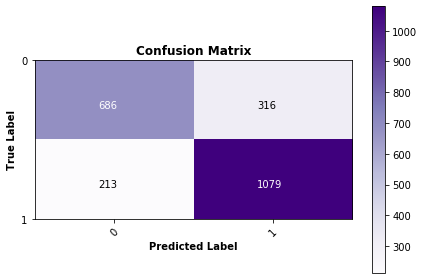

In [35]:
plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples)